# Waste Image Classification


## Import Libraries


In [1]:
# Import libraries for data loading
import os
import random

# Import libraries for data operations
import numpy as np
import pandas as pd
import math

# Import libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import textwrap


# Import libraries for feature engineering
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Import libraries for model creation
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, ReLU, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout

# Import libraries for model training
from sklearn.utils import class_weight
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Import libraries for model evaluation
from sklearn.metrics import confusion_matrix, classification_report

# Import libraries for pre-trained model
from tensorflow.keras.applications import InceptionV3

# Import libraries for warnings 
import warnings
warnings.filterwarnings('ignore')

In [7]:
# Check if TensorFlow is using GPU
print("Is TensorFlow using GPU:", tf.test.is_built_with_cuda())

# List available GPUs
# print("Available GPUs:", tf.config.list_physical_devices('GPU'))
print("Available GPUs:", len(tf.config.experimental.list_physical_devices('GPU')))

# Set TensorFlow to use GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


Is TensorFlow using GPU: True
Available GPUs: 1


## Data Loading


In [1]:
# Define the path to the dataset
dataset_path = "D:\\Codes\\Projects\\Waste Management using ML\\model-to-classify-waste-into-different-categories\\RealWaste"

# Define classes
classes = ["Cardboard", "Food Organics", "Glass", "Metal", "Miscellaneous Trash", "Paper", "Plastic", "Textile Trash", "Vegetation"]

In [3]:
# Define the paths for each class
class_paths = {cls: os.path.join(dataset_path, cls) for cls in classes}

# Function to list files in a directory
def list_files(directory_path):
    return os.listdir(directory_path)

# List files in each directory
print("Paths to dataset folder:")
print("Dataset Path:", dataset_path)
print("\nFiles in each folder:")
for cls, path in class_paths.items():
    files = list_files(path)
    print(f"\n{cls}:")
    for file in files[:5]:  # Display only the first 5 files
        print(f"  - {file}")
    if len(files) > 5:
        print(f"  ... and {len(files) - 5} more files")


Paths to dataset folder:
Dataset Path: D:\Codes\Projects\Waste Management using ML\model-to-classify-waste-into-different-categories\RealWaste

Files in each folder:

Cardboard:
  - Cardboard_1.jpg
  - Cardboard_10.jpg
  - Cardboard_100.jpg
  - Cardboard_101.jpg
  - Cardboard_102.jpg
  ... and 456 more files

Food Organics:
  - Food Organics_1.jpg
  - Food Organics_10.jpg
  - Food Organics_100.jpg
  - Food Organics_101.jpg
  - Food Organics_102.jpg
  ... and 406 more files

Glass:
  - Glass_1.jpg
  - Glass_10.jpg
  - Glass_100.jpg
  - Glass_101.jpg
  - Glass_102.jpg
  ... and 415 more files

Metal:
  - Metal_1.jpg
  - Metal_10.jpg
  - Metal_100.jpg
  - Metal_101.jpg
  - Metal_102.jpg
  ... and 785 more files

Miscellaneous Trash:
  - Miscellaneous Trash_1.jpg
  - Miscellaneous Trash_10.jpg
  - Miscellaneous Trash_100.jpg
  - Miscellaneous Trash_101.jpg
  - Miscellaneous Trash_102.jpg
  ... and 490 more files

Paper:
  - Paper_1.jpg
  - Paper_10.jpg
  - Paper_100.jpg
  - Paper_101.jpg
 

The next step is to count the total number of images in each folder to determine their number.

In [4]:
# Function to count files in a folder
def count_files(folder_path):
    file_list = os.listdir(folder_path)
    return len(file_list)

# Create a dictionary with class names and counts
classes_dict = {cls: count_files(class_paths[cls]) for cls in classes}

# Create a DataFrame from the dictionary
classes_df = pd.DataFrame.from_dict(classes_dict, orient='index', columns=['Number of Images'])

# Sort the DataFrame by 'Number of Images' in descending order
classes_df_sorted = classes_df.sort_values('Number of Images', ascending=False)

# Display the sorted DataFrame
classes_df_sorted

Number of Images
Plastic                           921
Metal                             790
Paper                             500
Miscellaneous Trash               495
Cardboard                         461
Vegetation                        436
Glass                             420
Food Organics                     411
Textile Trash                     318

In [5]:
# Define path list
path_list = [class_paths[cls] for cls in classes]

# Create empty list of image path and class
image_path = []
class_labels = []

# Iterate through all of the images in the path list to extract path and class
for i, dir_path in enumerate(path_list):
    image_names = os.listdir(dir_path)
    for name_file in image_names:
        full_image_path = os.path.join(dir_path, name_file)
        image_path.append(full_image_path)
        class_labels.append(classes[i])

# Create a dataframe
df = pd.DataFrame({
    "Image_Path": image_path,
    "Class": class_labels
})

# Show the first 5 rows
df.head()

Image_Path      Class
0  D:\Codes\Projects\Waste Management using ML\mo...  Cardboard
1  D:\Codes\Projects\Waste Management using ML\mo...  Cardboard
2  D:\Codes\Projects\Waste Management using ML\mo...  Cardboard
3  D:\Codes\Projects\Waste Management using ML\mo...  Cardboard
4  D:\Codes\Projects\Waste Management using ML\mo...  Cardboard

## Exploratory Data Analysis (EDA)


### 1. Image Visualization

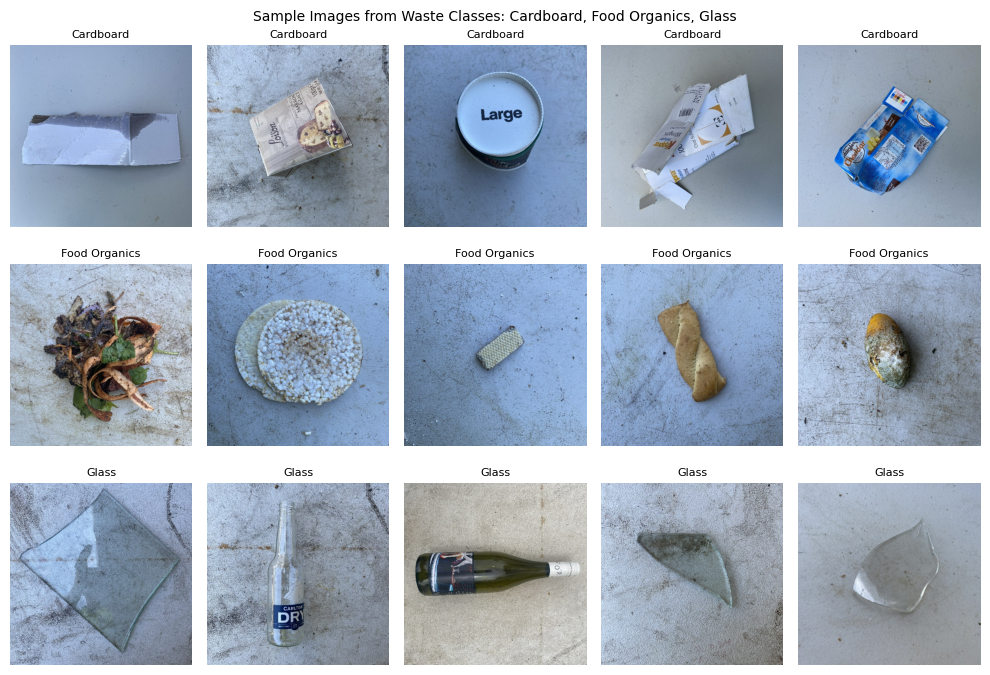

In [7]:
# Set a fixed random seed
random.seed(42)
np.random.seed(42)

# Extract 5 samples from each class
sampled_df = pd.concat([df[df['Class'] == cls].sample(5, random_state=42) for cls in classes])

def plot_waste_images(class_names):
    # Create a 3x5 grid of subplots
    fig, axes = plt.subplots(3, 5, figsize=(10, 7))
    # Set the main title for the entire figure
    fig.suptitle(f'Sample Images from Waste Classes: {", ".join(class_names)}', fontsize=10)

    # Iterate through the specified waste classes
    for i, cls in enumerate(class_names):
        # Select samples for the current class
        class_samples = sampled_df[sampled_df['Class'] == cls]
        
        # Plot five images for each class
        for j, (_, row) in enumerate(class_samples.iterrows()):
            # Read the image and convert from BGR to RGB
            img = cv2.imread(row['Image_Path'])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # Display the image in the appropriate subplot
            axes[i, j].imshow(img)
            axes[i, j].set_title(cls, fontsize=8)
            axes[i, j].axis('off')  # Remove axis ticks and labels

    # Adjust the layout and spacing
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    # Display the plot
    plt.show()

# Plot first 3 classes
plot_waste_images(classes[:3])

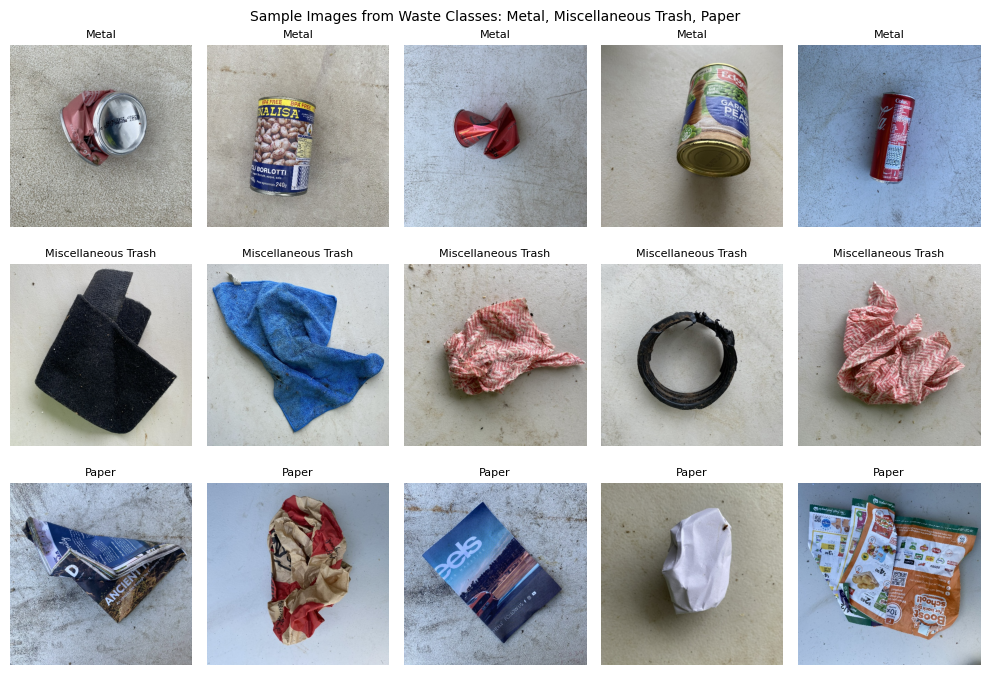

In [ ]:
# Plot middle 3 classes
plot_waste_images(classes[3:6])

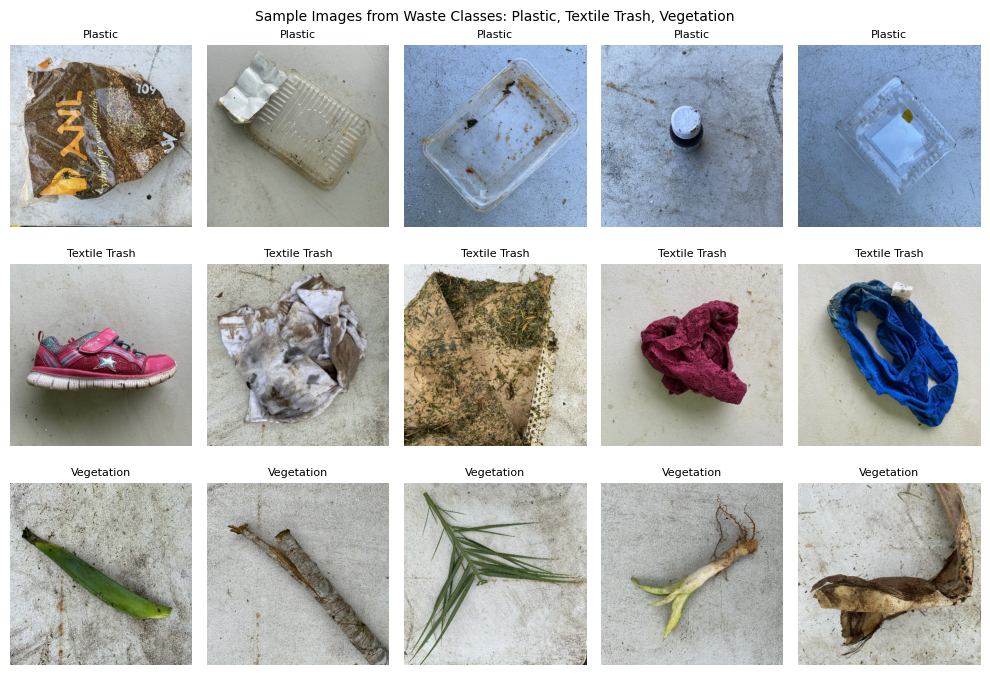

In [9]:
plot_waste_images(classes[6:])

### 2. Class Distribution

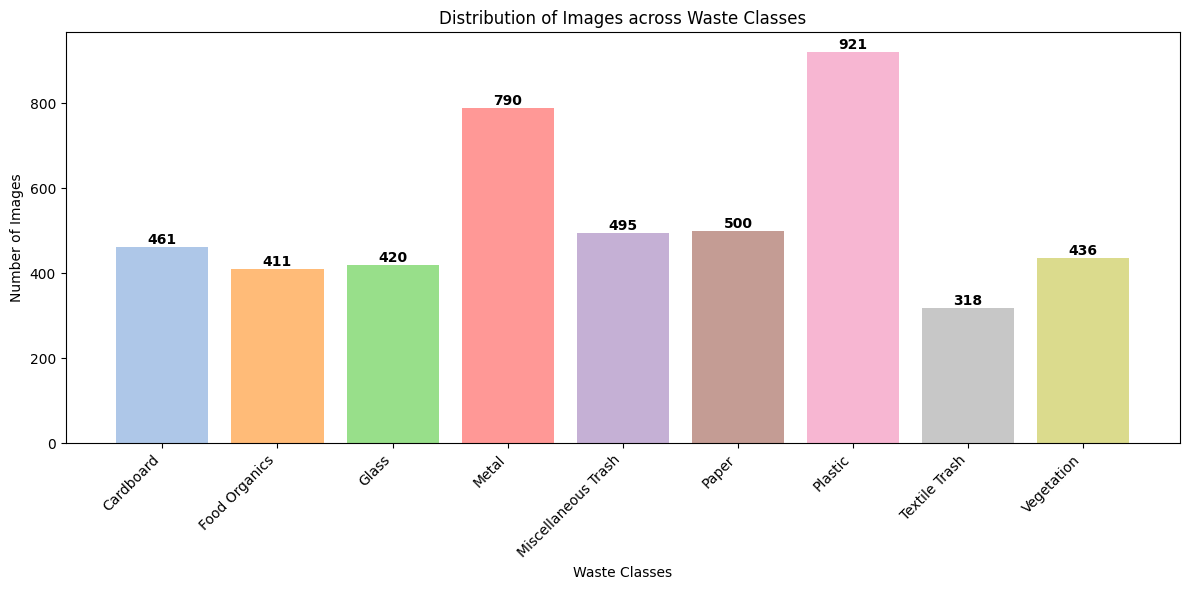

In [10]:
# Counts occurrences of each class
class_counts = df['Class'].value_counts().sort_index()

# Define list of colors for 9 classes (lighter palette)
colors = ['#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5', 
          '#c49c94', '#f7b6d2', '#c7c7c7', '#dbdb8d']

# Plot the graph
plt.figure(figsize=(12, 6))
bars = plt.bar(class_counts.index, class_counts.values, color=colors)
plt.xlabel('Waste Classes')
plt.ylabel('Number of Images')
plt.title('Distribution of Images across Waste Classes')

# Add the number of counts on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), 
             ha='center', va='bottom', fontweight='bold')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust layout to prevent cutting off labels
plt.tight_layout()

plt.show()

### 3. Shape Distribution

In [11]:
# Function to get image dimensions
def get_image_dimensions(image_path):
    img = cv2.imread(image_path)
    return img.shape[:2]  # Returns (height, width)

# Get dimensions of the first image
first_image_path = df['Image_Path'].iloc[0]
first_image_dimensions = get_image_dimensions(first_image_path)

# Check if all other images have the same dimensions
all_same_size = all(get_image_dimensions(path) == first_image_dimensions for path in df['Image_Path'])

# Print the results
print(f"All images have the same size: {all_same_size}")
print(f"Image dimensions (height x width): {first_image_dimensions[0]} x {first_image_dimensions[1]}")

All images have the same size: True
Image dimensions (height x width): 524 x 524


### 4. Color Distribution

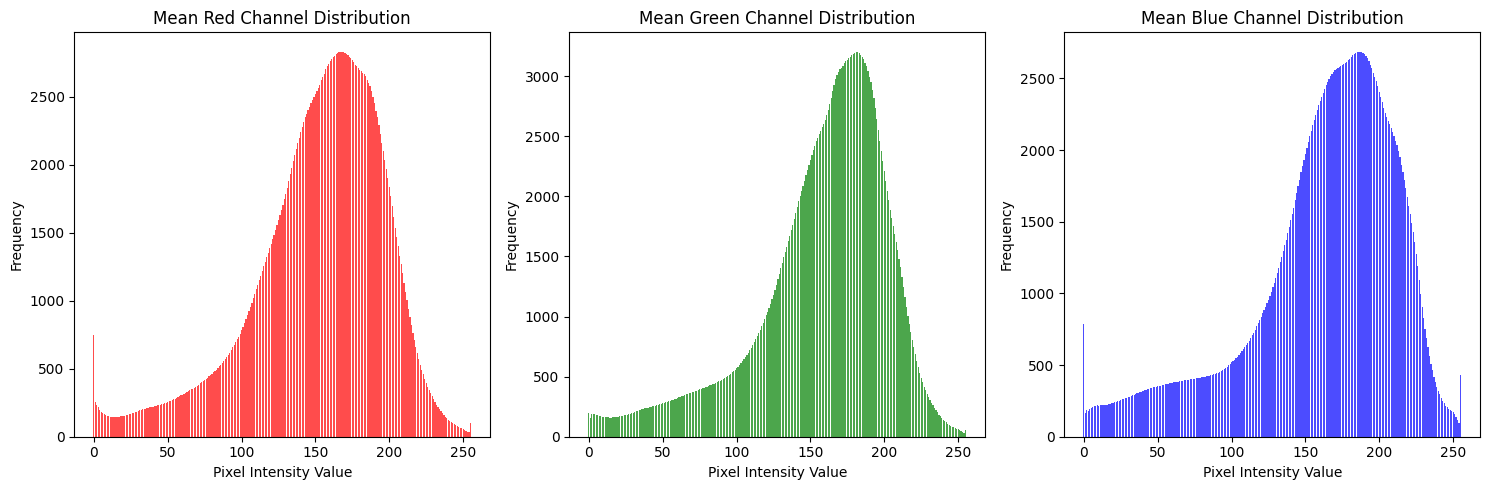

Average pixel intensities:
Red: 1072.56
Green: 1072.56
Blue: 1072.56

Most common pixel intensities:
Red: 167
Green: 182
Blue: 187


In [12]:
# Create empty lists for each color channel
red_distributions = []
green_distributions = []
blue_distributions = []

# Iterate through a sample of images (e.g., 1000 images)
sample_size = min(1000, len(df))
for img_path in df['Image_Path'].sample(sample_size, random_state=42):
    # Load image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Extract color distributions for each channel
    red_distributions.append(np.bincount(img[:,:,0].flatten(), minlength=256))
    green_distributions.append(np.bincount(img[:,:,1].flatten(), minlength=256))
    blue_distributions.append(np.bincount(img[:,:,2].flatten(), minlength=256))

# Convert to numpy arrays
red_distributions = np.array(red_distributions)
green_distributions = np.array(green_distributions)
blue_distributions = np.array(blue_distributions)

# Calculate mean distributions
mean_red = np.mean(red_distributions, axis=0)
mean_green = np.mean(green_distributions, axis=0)
mean_blue = np.mean(blue_distributions, axis=0)

# Plotting the color distributions
plt.figure(figsize=(15, 5))

# Red channel
plt.subplot(131)
plt.bar(range(256), mean_red, color='red', alpha=0.7)
plt.title('Mean Red Channel Distribution')
plt.xlabel('Pixel Intensity Value')
plt.ylabel('Frequency')

# Green channel
plt.subplot(132)
plt.bar(range(256), mean_green, color='green', alpha=0.7)
plt.title('Mean Green Channel Distribution')
plt.xlabel('Pixel Intensity Value')
plt.ylabel('Frequency')

# Blue channel
plt.subplot(133)
plt.bar(range(256), mean_blue, color='blue', alpha=0.7)
plt.title('Mean Blue Channel Distribution')
plt.xlabel('Pixel Intensity Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Print some statistics
print(f"Average pixel intensities:")
print(f"Red: {np.mean(mean_red):.2f}")
print(f"Green: {np.mean(mean_green):.2f}")
print(f"Blue: {np.mean(mean_blue):.2f}")

print(f"\nMost common pixel intensities:")
print(f"Red: {np.argmax(mean_red)}")
print(f"Green: {np.argmax(mean_green)}")
print(f"Blue: {np.argmax(mean_blue)}")

### 5. Pixel Intensity Distribution

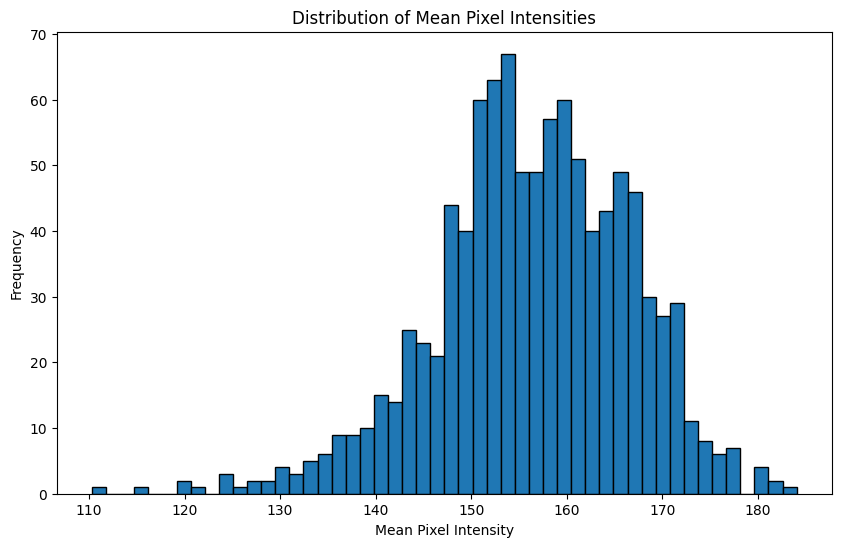

Overall Statistics:
Mean Pixel Intensity: 156.35 ± 10.30
Average Standard Deviation: 41.31
Average Min Pixel Value: 0.95
Average Max Pixel Value: 251.09

Potentially Overexposed Images: 0 (0.00%)
Potentially Underexposed Images: 0 (0.00%)
Images with unusually low brightness: 15 (1.50%)
Images with unusually high brightness: 0 (0.00%)


In [13]:
# Function to calculate pixel intensity statistics
def get_pixel_stats(image):
    return {
        'mean': np.mean(image),
        'std': np.std(image),
        'min': np.min(image),
        'max': np.max(image)
    }

# Lists to store statistics
means, stds, mins, maxs = [], [], [], []

# Sample size (adjust as needed), lets just take 1000 samples for this case
sample_size = min(1000, len(df))

# Process images
for img_path in df['Image_Path'].sample(sample_size, random_state=42):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    stats = get_pixel_stats(img)
    means.append(stats['mean'])
    stds.append(stats['std'])
    mins.append(stats['min'])
    maxs.append(stats['max'])

# Plot histogram of mean pixel intensities
plt.figure(figsize=(10, 6))
plt.hist(means, bins=50, edgecolor='black')
plt.title('Distribution of Mean Pixel Intensities')
plt.xlabel('Mean Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

# Print overall statistics
print(f"Overall Statistics:")
print(f"Mean Pixel Intensity: {np.mean(means):.2f} ± {np.std(means):.2f}")
print(f"Average Standard Deviation: {np.mean(stds):.2f}")
print(f"Average Min Pixel Value: {np.mean(mins):.2f}")
print(f"Average Max Pixel Value: {np.mean(maxs):.2f}")

# Check for potential overexposure or underexposure
overexposed = sum(m > 240 for m in means)
underexposed = sum(m < 15 for m in means)
print(f"\nPotentially Overexposed Images: {overexposed} ({overexposed/sample_size*100:.2f}%)")
print(f"Potentially Underexposed Images: {underexposed} ({underexposed/sample_size*100:.2f}%)")

# Calculate Q1, Q3, and IQR for mean pixel intensities
Q1 = np.percentile(means, 25)
Q3 = np.percentile(means, 75)
IQR = Q3 - Q1

# Define outliers as 1.5 IQR below Q1 or above Q3
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count outliers
low_outliers = sum(m < lower_bound for m in means)
high_outliers = sum(m > upper_bound for m in means)

print(f"Images with unusually low brightness: {low_outliers} ({low_outliers/sample_size*100:.2f}%)")
print(f"Images with unusually high brightness: {high_outliers} ({high_outliers/sample_size*100:.2f}%)")

## Feature Engineering


### 1. Split Train, Validation, and Test Set

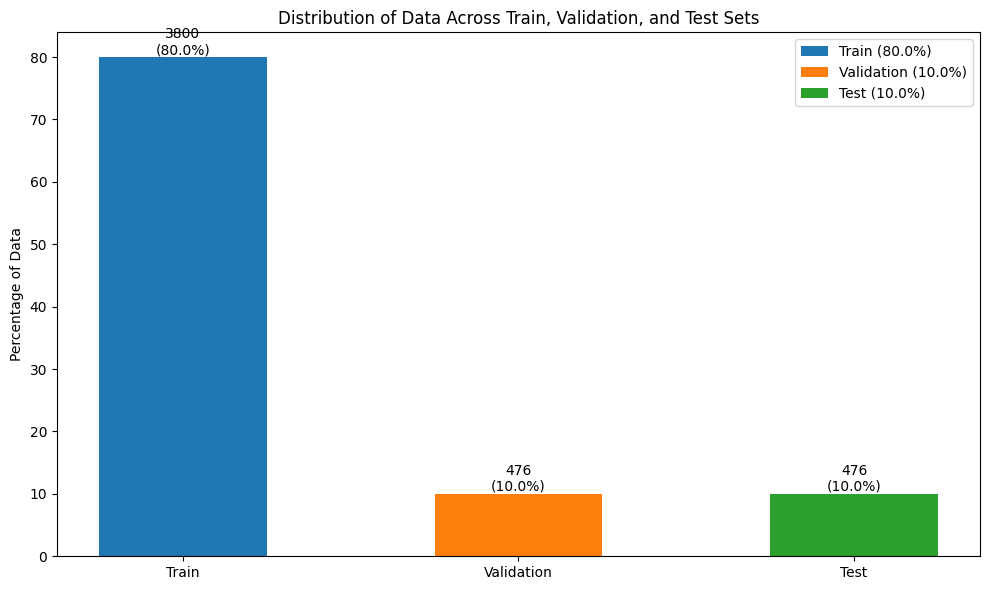

In [ ]:
# Define ratio
train_ratio = 0.80
val_ratio = 0.10
test_ratio = 0.10

# Split train and test first
df_train_val, df_test = train_test_split(df, test_size=test_ratio, stratify=df['Class'], random_state=42)

# Then split train_val into train and validation
df_train, df_val = train_test_split(df_train_val, test_size=val_ratio/(train_ratio+val_ratio), stratify=df_train_val['Class'], random_state=42)

# Prepare data for visualization
datasets = [df_train, df_val, df_test]
names = ['Train', 'Validation', 'Test']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green

# Create the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(names))
total = len(df)
widths = [len(d) / total for d in datasets]

for i, (dataset, name, color) in enumerate(zip(datasets, names, colors)):
    count = len(dataset)
    percentage = count / total * 100
    ax.bar(i, percentage, width=0.5, color=color, label=f'{name} ({percentage:.1f}%)')
    ax.text(i, percentage, f'{count}\n({percentage:.1f}%)', ha='center', va='bottom')

ax.set_ylabel('Percentage of Data')
ax.set_title('Distribution of Data Across Train, Validation, and Test Sets')
ax.set_xticks(x)
ax.set_xticklabels(names)
ax.legend()

plt.tight_layout()
plt.show()

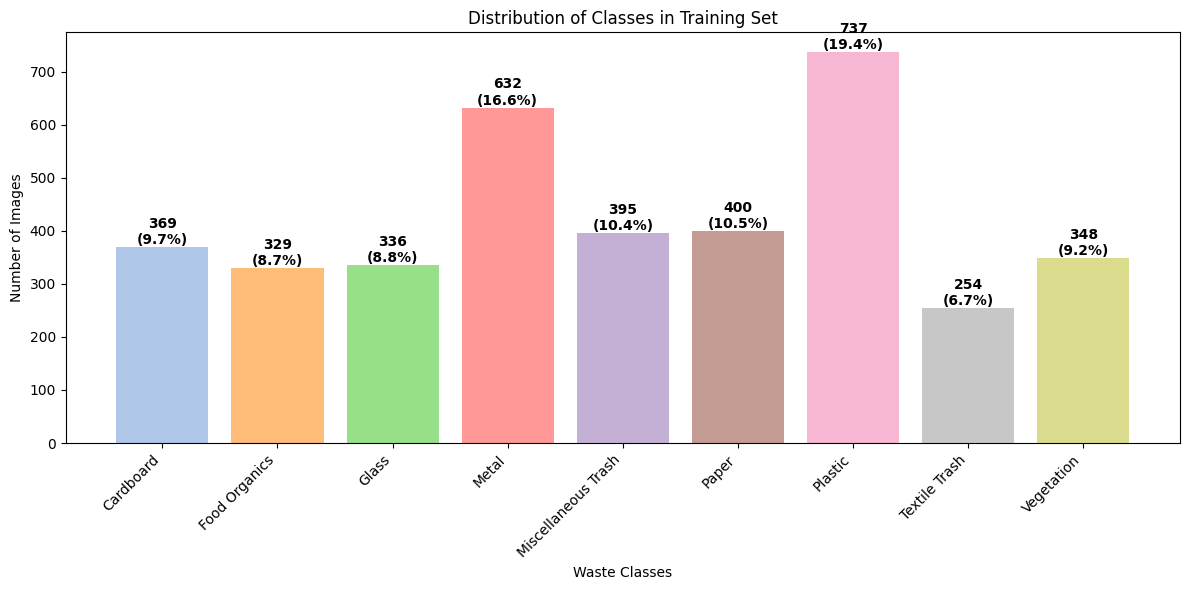

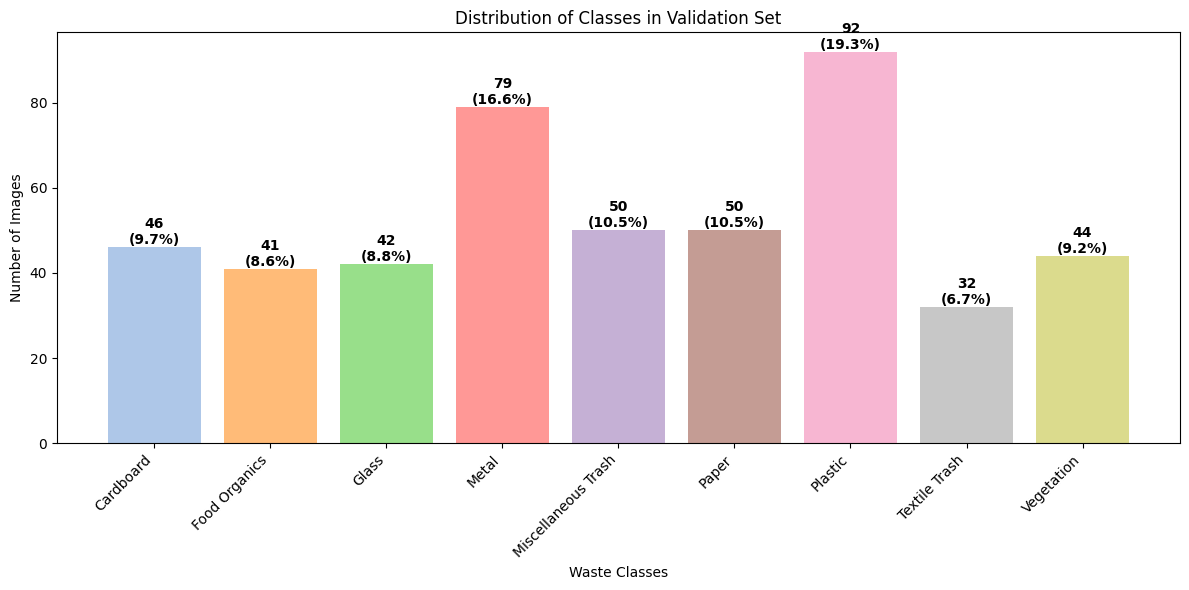

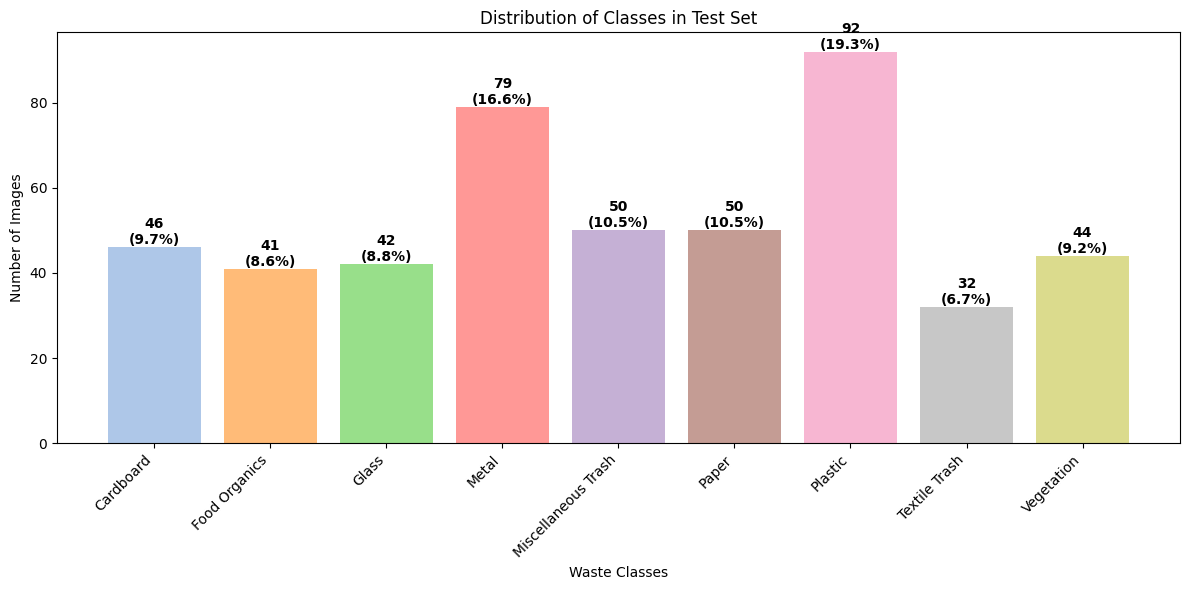

In [17]:
# Define colors
colors = ['#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5', 
          '#c49c94', '#f7b6d2', '#c7c7c7', '#dbdb8d']

# Plot class disrbution for each df train, val, test
def plot_class_distribution(dataset, title):
    class_counts = dataset['Class'].value_counts().sort_index()
    
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.bar(class_counts.index, class_counts.values, color=colors)
    
    ax.set_xlabel('Waste Classes')
    ax.set_ylabel('Number of Images')
    ax.set_title(f'Distribution of Classes in {title} Set')
    
    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height,
                f'{height}\n({height/len(dataset):.1%})',
                ha='center', va='bottom', fontweight='bold')
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Plot distribution for each dataset
plot_class_distribution(df_train, 'Training')
plot_class_distribution(df_val, 'Validation')
plot_class_distribution(df_test, 'Test')

### 2. Data Pre-processing

In [18]:
# Define image size and batch size
width = 299
height = 299
image_size = (width, height)

In [19]:
# Define generator for training with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,        # Randomly rotate images in the range (degrees) -< 90
    shear_range=45,           # Shear angle in counter-clockwise direction in degrees -< 45
    horizontal_flip=True,     # Randomly flip images
    fill_mode='nearest'       # Fill in new pixels
)

# Define generator for validation and testing (only rescaling, no augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators for training, validation, and testing sets
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col="Image_Path",
    y_col="Class",
    target_size=image_size,
    batch_size=32,
    # color_mode="rgb",
    class_mode="categorical",
    shuffle=False
)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=df_val,
    x_col="Image_Path",
    y_col="Class",
    target_size=image_size,
    batch_size=32,
    # color_mode="rgb",
    class_mode="categorical",
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col="Image_Path",
    y_col="Class",
    target_size=image_size,
    batch_size=32,
    # color_mode="rgb",
    class_mode="categorical",
    shuffle=False
)

Found 3800 validated image filenames belonging to 9 classes.
Found 476 validated image filenames belonging to 9 classes.
Found 476 validated image filenames belonging to 9 classes.


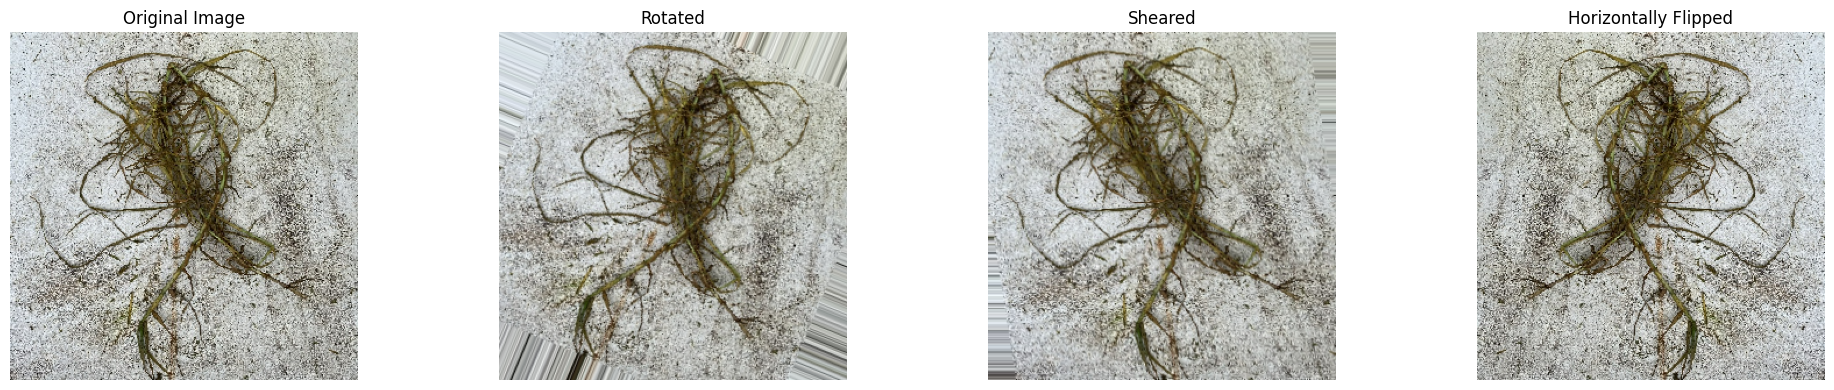

Class of the displayed image: Vegetation


In [20]:
def plot_images(original_image, augmented_images, augmentation_types):
    n = len(augmented_images)
    plt.figure(figsize=(20, 4))
    plt.subplot(1, n+1, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')
    
    for i in range(n):
        plt.subplot(1, n+1, i+2)
        plt.imshow(augmented_images[i])
        plt.title(augmentation_types[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Load a specific image 
image_path = df_train['Image_Path'].iloc[69]  # Using the image number 69 (lol) in df_train
original_image = load_img(image_path, target_size=image_size)
original_image_array = img_to_array(original_image) / 255.0  # Normalize to [0,1]

# Create separate image generators for each augmentation
rotation_gen = ImageDataGenerator(rotation_range=90)
shear_gen = ImageDataGenerator(shear_range=45)

# Generate augmented images
rotated_image = rotation_gen.random_transform(original_image_array)
sheared_image = shear_gen.random_transform(original_image_array)

# Force horizontal flip
flipped_image = np.fliplr(original_image_array)

# Combine augmented images and their labels
augmented_images = [rotated_image, sheared_image, flipped_image]
augmentation_types = ['Rotated', 'Sheared', 'Horizontally Flipped']

# Plot original and augmented images
plot_images(original_image, augmented_images, augmentation_types)

# Print the class of the selected image
class_name = df_train['Class'].iloc[69]
print(f"Class of the displayed image: {class_name}")

## ANN Training (Sequential API)


### 1. Model Definition


In [21]:
# Clear Session

seed = 42
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# Create the model
first_model = Sequential()

# First Conv Block
first_model.add(Conv2D(32, (3, 3), padding='same', input_shape=(299, 299, 3)))
first_model.add(BatchNormalization())
first_model.add(ReLU())
first_model.add(MaxPooling2D((2, 2)))

# Second Conv Block
first_model.add(Conv2D(64, (3, 3), padding='same'))
first_model.add(BatchNormalization())
first_model.add(ReLU())
first_model.add(MaxPooling2D((2, 2)))

# Third Conv Block
first_model.add(Conv2D(128, (3, 3), padding='same'))
first_model.add(BatchNormalization())
first_model.add(ReLU())
first_model.add(MaxPooling2D((2, 2)))

# Global Average Pooling
first_model.add(GlobalAveragePooling2D())

# Fully connected layers
first_model.add(Dense(256, activation='relu'))
first_model.add(Dropout(0.5))

# Output layer
first_model.add(Dense(9, activation='softmax'))  # 9 classes for waste classification

# Compile the model
first_model.compile(optimizer=Adam(learning_rate=0.001),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

In [ ]:
# Display the model summary
first_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 299, 299, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 299, 299, 32)     128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 299, 299, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 149, 149, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 149, 149, 64)     2

### 2. Model Training


In [25]:
# Define classes
classes = list(train_generator.class_indices.keys())

# Apply class weight to handle imbalance data
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                  classes = np.unique(train_generator.classes),
                                                  y = train_generator.classes)

train_class_weights = dict(enumerate(class_weights))

for idx, weight in train_class_weights.items():
    class_name = classes[idx]
    print(f"{class_name} : {weight:.2f}")

Cardboard : 1.14
Food Organics : 1.28
Glass : 1.26
Metal : 0.67
Miscellaneous Trash : 1.07
Paper : 1.06
Plastic : 0.57
Textile Trash : 1.66
Vegetation : 1.21


In [ ]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True,
    verbose=1
) 

In [ ]:
# Train the model
history_first_model = first_model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    class_weight=train_class_weights,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
119/119 [==============================] - 41s 304ms/step - loss: 1.7267 - accuracy: 0.3479 - val_loss: 2.8159 - val_accuracy: 0.0861
Epoch 2/50
119/119 [==============================] - 39s 326ms/step - loss: 1.4530 - accuracy: 0.4413 - val_loss: 3.2252 - val_accuracy: 0.1975
Epoch 3/50
119/119 [==============================] - 39s 330ms/step - loss: 1.3676 - accuracy: 0.4811 - val_loss: 4.2491 - val_accuracy: 0.1618
Epoch 4/50
119/119 [==============================] - 39s 328ms/step - loss: 1.3162 - accuracy: 0.5024 - val_loss: 2.8193 - val_accuracy: 0.2416
Epoch 5/50
119/119 [==============================] - 39s 327ms/step - loss: 1.2486 - accuracy: 0.5303 - val_loss: 1.7399 - val_accuracy: 0.3866
Epoch 6/50
119/119 [==============================] - 39s 327ms/step - loss: 1.2045 - accuracy: 0.5374 - val_loss: 1.7397 - val_accuracy: 0.3782
Epoch 7/50
119/119 [==============================] - 39s 326ms/step - loss: 1.1636 - accuracy: 0.5487 - val_loss: 3.7166 - val_ac

### 3. Model Evaluation


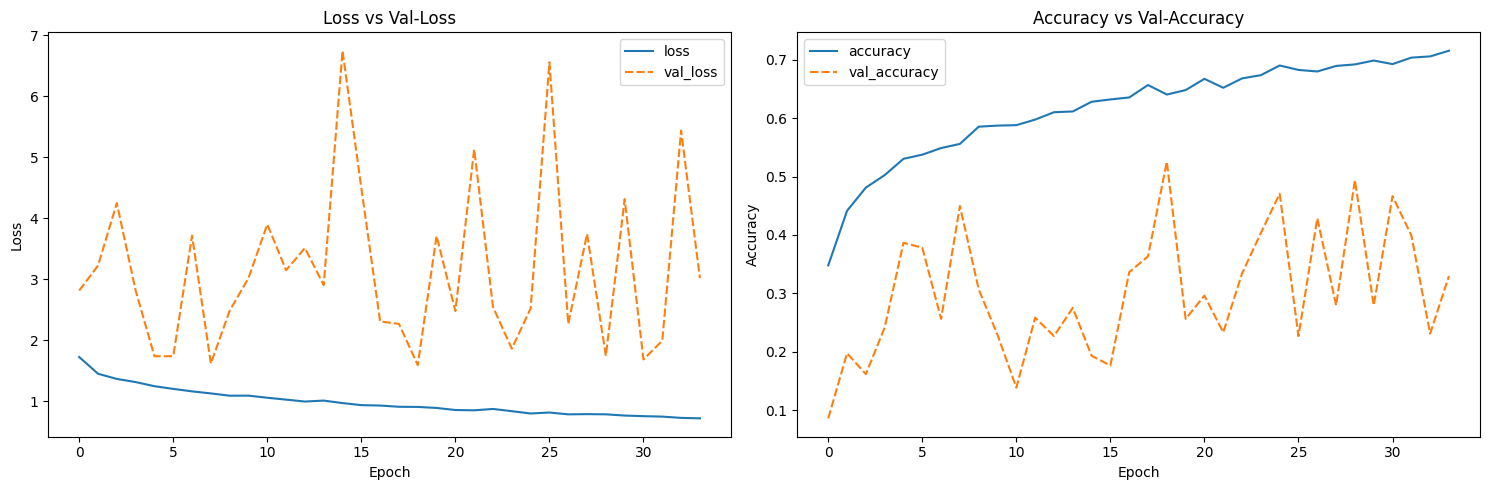

In [ ]:
# Plot training results

history_first_model_df = pd.DataFrame(history_first_model.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_first_model_df[['loss', 'val_loss']])
plt.title('Loss vs Val-Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_first_model_df[['accuracy', 'val_accuracy']])
plt.title('Accuracy vs Val-Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
# Check the performance of train-set
# Get the probability predictions
y_pred_prob_train_first = first_model.predict(train_generator)

# Get class with maximum probability
y_pred_class_train_first = np.argmax(y_pred_prob_train_first, axis=-1)

# Get the true labels from the train data generator
y_true_train = train_generator.classes

# Get the class names from the training data generator
class_names = list(train_generator.class_indices.keys())

# Display Classification Report
print("Classification Report for Training Set:")
print(classification_report(y_true_train, y_pred_class_train_first, target_names=class_names))


119/119 [==============================] - 37s 310ms/step
Classification Report for Training Set:
                     precision    recall  f1-score   support

          Cardboard       0.46      0.91      0.61       369
      Food Organics       1.00      0.22      0.36       329
              Glass       0.70      0.62      0.66       336
              Metal       0.64      0.71      0.67       632
Miscellaneous Trash       0.42      0.53      0.47       395
              Paper       0.84      0.48      0.61       400
            Plastic       0.56      0.61      0.58       737
      Textile Trash       0.74      0.29      0.41       254
         Vegetation       0.83      0.85      0.84       348

           accuracy                           0.60      3800
          macro avg       0.69      0.58      0.58      3800
       weighted avg       0.66      0.60      0.59      3800



In [ ]:
# Check the performance of test-set
# Get the probability predictions
y_pred_prob_first = first_model.predict(test_generator)

# Get class with maximum probability
y_pred_class_first = np.argmax(y_pred_prob_first, axis=-1)

# Get the true labels from the test data generator
y_true = test_generator.classes

# Get the class names from the testing data generator
class_names = list(test_generator.class_indices.keys())

# Display Classification Report
print(classification_report(y_true, y_pred_class_first, target_names=class_names))

15/15 [==============================] - 1s 87ms/step
                     precision    recall  f1-score   support

          Cardboard       0.34      0.87      0.48        46
      Food Organics       0.00      0.00      0.00        41
              Glass       0.75      0.57      0.65        42
              Metal       0.79      0.63      0.70        79
Miscellaneous Trash       0.26      0.44      0.33        50
              Paper       0.66      0.46      0.54        50
            Plastic       0.60      0.54      0.57        92
      Textile Trash       0.75      0.19      0.30        32
         Vegetation       0.62      0.73      0.67        44

           accuracy                           0.52       476
          macro avg       0.53      0.49      0.47       476
       weighted avg       0.55      0.52      0.50       476



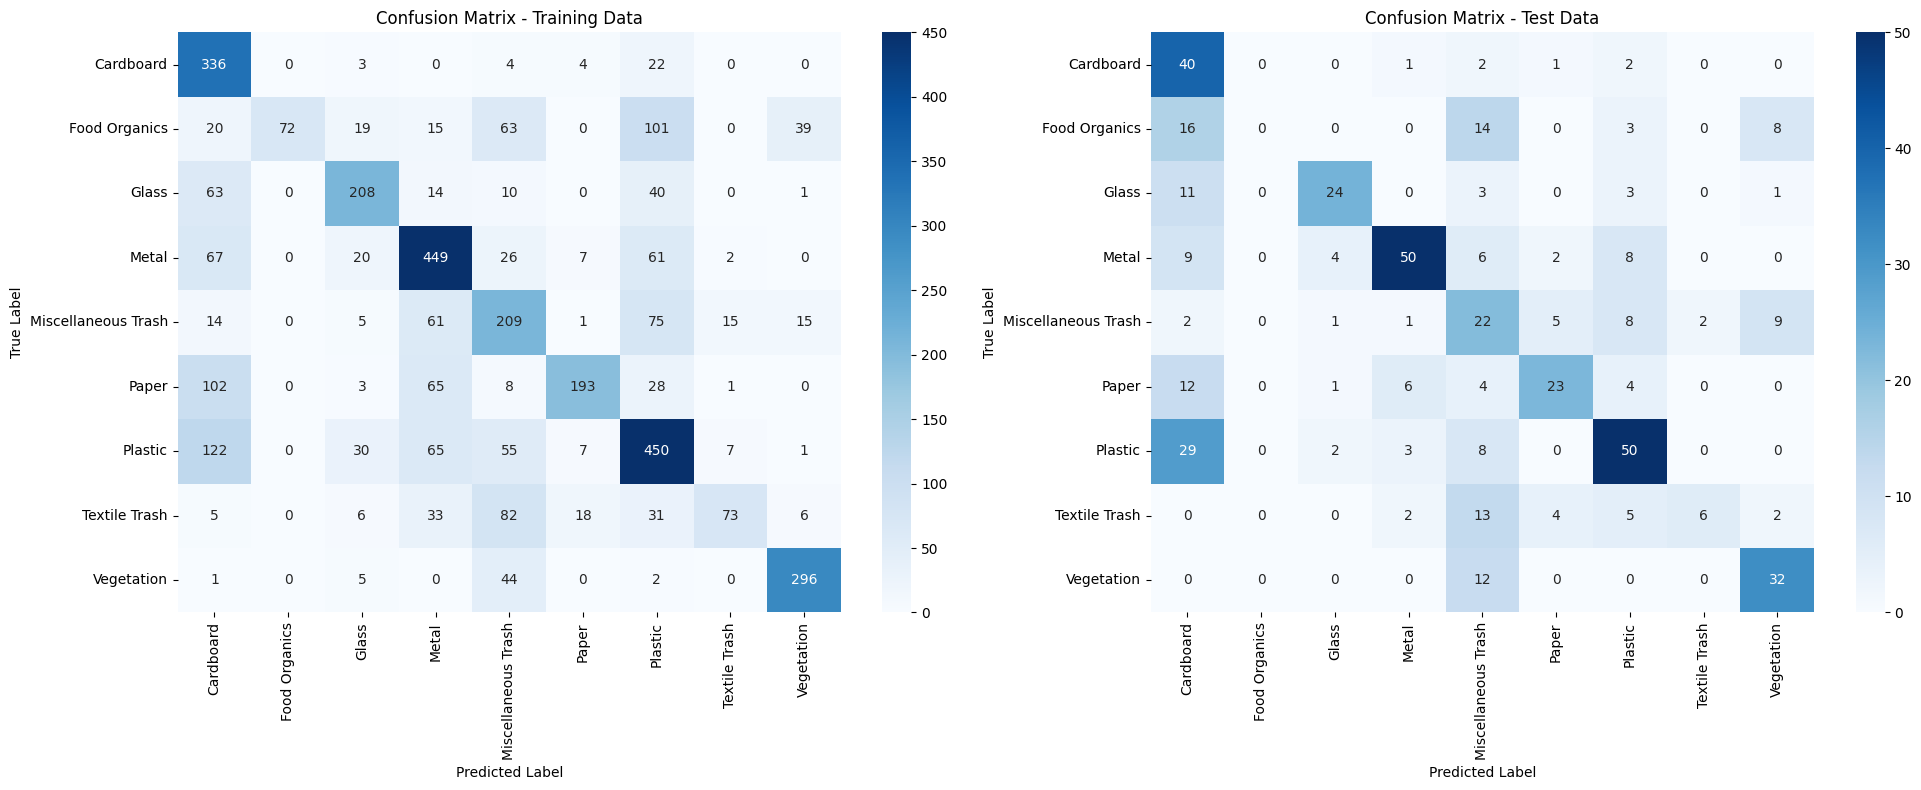

In [ ]:
# Generate the confusion matrices
cm_train_first = confusion_matrix(y_true_train, y_pred_class_train_first)
cm_test_first = confusion_matrix(y_true, y_pred_class_first)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot confusion matrix for the training data
sns.heatmap(cm_train_first, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_title('Confusion Matrix - Training Data')

# Plot confusion matrix for the test data
sns.heatmap(cm_test_first, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_title('Confusion Matrix - Test Data')

# Display the plots
plt.tight_layout()
plt.show()

## VII. ANN Improvement (Transfer Learning)


### 1. Model Definition


In [32]:
# Clear Session

seed = 42
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [33]:
# Load the pre-trained InceptionV3 model, exclude top layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze all layers except the last 5 layers
for layer in base_model.layers[:-5]:  # Unfreeze the last 5 layers for fine-tuning
    layer.trainable = False

# Build the model
model = Sequential()

# Add the base pre-trained model
model.add(base_model)

# Add global average pooling to reduce the output dimensions
model.add(GlobalAveragePooling2D())

# Add a fully connected layer with dropout for regularization
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Dropout with 50% probability to reduce overfitting

# Add the output layer
model.add(Dense(9, activation='softmax'))

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [34]:
# summary of transfer learning model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 9)                 2313      
                                                                 
Total params: 22,329,641
Trainable params: 526,857
Non-trainable params: 21,802,784
______________________________________

### 2. Model Training


In [35]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    class_weight=train_class_weights,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
119/119 [==============================] - 43s 340ms/step - loss: 1.5635 - accuracy: 0.4242 - val_loss: 1.1340 - val_accuracy: 0.6155
Epoch 2/50
119/119 [==============================] - 39s 329ms/step - loss: 1.0974 - accuracy: 0.5945 - val_loss: 0.9611 - val_accuracy: 0.6786
Epoch 3/50
119/119 [==============================] - 40s 333ms/step - loss: 0.9893 - accuracy: 0.6350 - val_loss: 0.9182 - val_accuracy: 0.6618
Epoch 4/50
119/119 [==============================] - 40s 335ms/step - loss: 0.9334 - accuracy: 0.6442 - val_loss: 0.8856 - val_accuracy: 0.6891
Epoch 5/50
119/119 [==============================] - 40s 332ms/step - loss: 0.8599 - accuracy: 0.6774 - val_loss: 0.8138 - val_accuracy: 0.7143
Epoch 6/50
119/119 [==============================] - 39s 330ms/step - loss: 0.8292 - accuracy: 0.6937 - val_loss: 0.8103 - val_accuracy: 0.7017
Epoch 7/50
119/119 [==============================] - 40s 333ms/step - loss: 0.8031 - accuracy: 0.6968 - val_loss: 0.8535 - val_ac

### 3. Model Evaluation


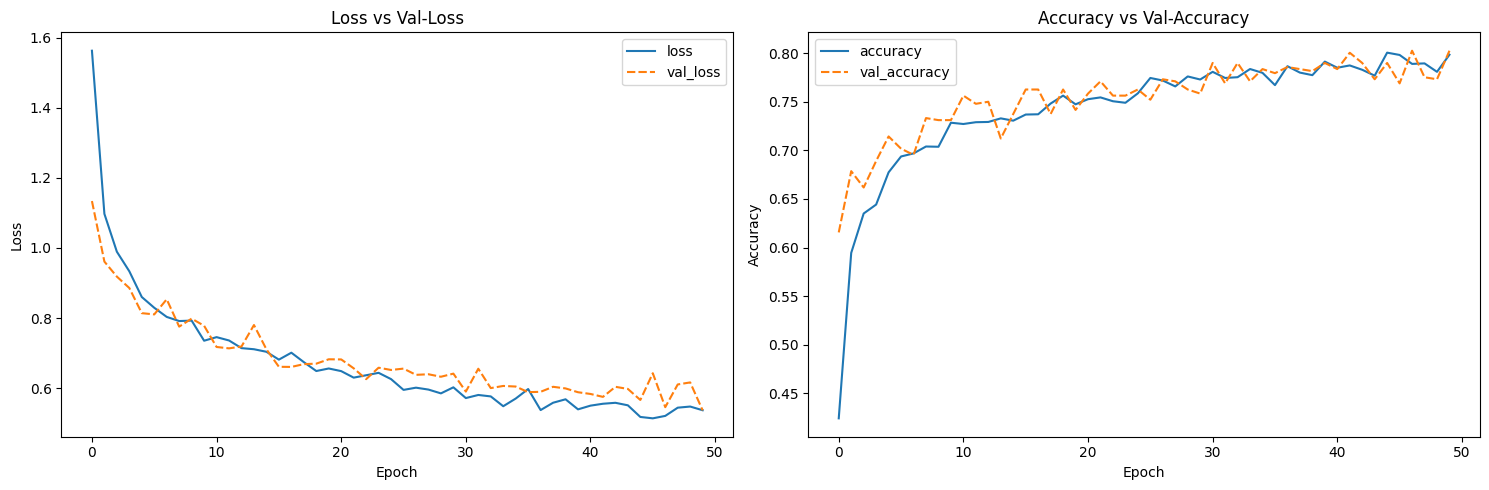

In [36]:
# Plot training results

history_model_df = pd.DataFrame(history.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_model_df[['loss', 'val_loss']])
plt.title('Loss vs Val-Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_model_df[['accuracy', 'val_accuracy']])
plt.title('Accuracy vs Val-Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [37]:
# Check the performance of train-set
# Get the probability predictions
y_pred_prob_train = model.predict(train_generator)

# Get class with maximum probability
y_pred_class_train = np.argmax(y_pred_prob_train, axis=-1)

# Get the true labels from the train data generator
y_true_train = train_generator.classes

# Get the class names from the training data generator
class_names = list(train_generator.class_indices.keys())

# Display Classification Report
print(classification_report(y_true_train, y_pred_class_train, target_names=class_names))

119/119 [==============================] - 39s 323ms/step
                     precision    recall  f1-score   support

          Cardboard       0.84      0.86      0.85       369
      Food Organics       0.88      0.95      0.92       329
              Glass       0.83      0.94      0.88       336
              Metal       0.91      0.83      0.87       632
Miscellaneous Trash       0.83      0.80      0.82       395
              Paper       0.93      0.87      0.90       400
            Plastic       0.84      0.84      0.84       737
      Textile Trash       0.85      0.91      0.88       254
         Vegetation       0.96      0.96      0.96       348

           accuracy                           0.87      3800
          macro avg       0.88      0.88      0.88      3800
       weighted avg       0.87      0.87      0.87      3800



In [38]:
# Check the performance of test-set
# Get the probability predictions
y_pred_prob = model.predict(test_generator)

# Get class with maximum probability
y_pred_class = np.argmax(y_pred_prob, axis=-1)

# Get the true labels from the test data generator
y_true = test_generator.classes

# Get the class names from the testing data generator
class_names = list(test_generator.class_indices.keys())

# Display Classification Report
print(classification_report(y_true, y_pred_class, target_names=class_names))

15/15 [==============================] - 2s 114ms/step
                     precision    recall  f1-score   support

          Cardboard       0.75      0.87      0.81        46
      Food Organics       0.88      0.68      0.77        41
              Glass       0.75      0.95      0.84        42
              Metal       0.85      0.86      0.86        79
Miscellaneous Trash       0.67      0.74      0.70        50
              Paper       0.88      0.84      0.86        50
            Plastic       0.93      0.67      0.78        92
      Textile Trash       0.77      0.94      0.85        32
         Vegetation       0.86      0.95      0.90        44

           accuracy                           0.82       476
          macro avg       0.81      0.83      0.82       476
       weighted avg       0.83      0.82      0.82       476



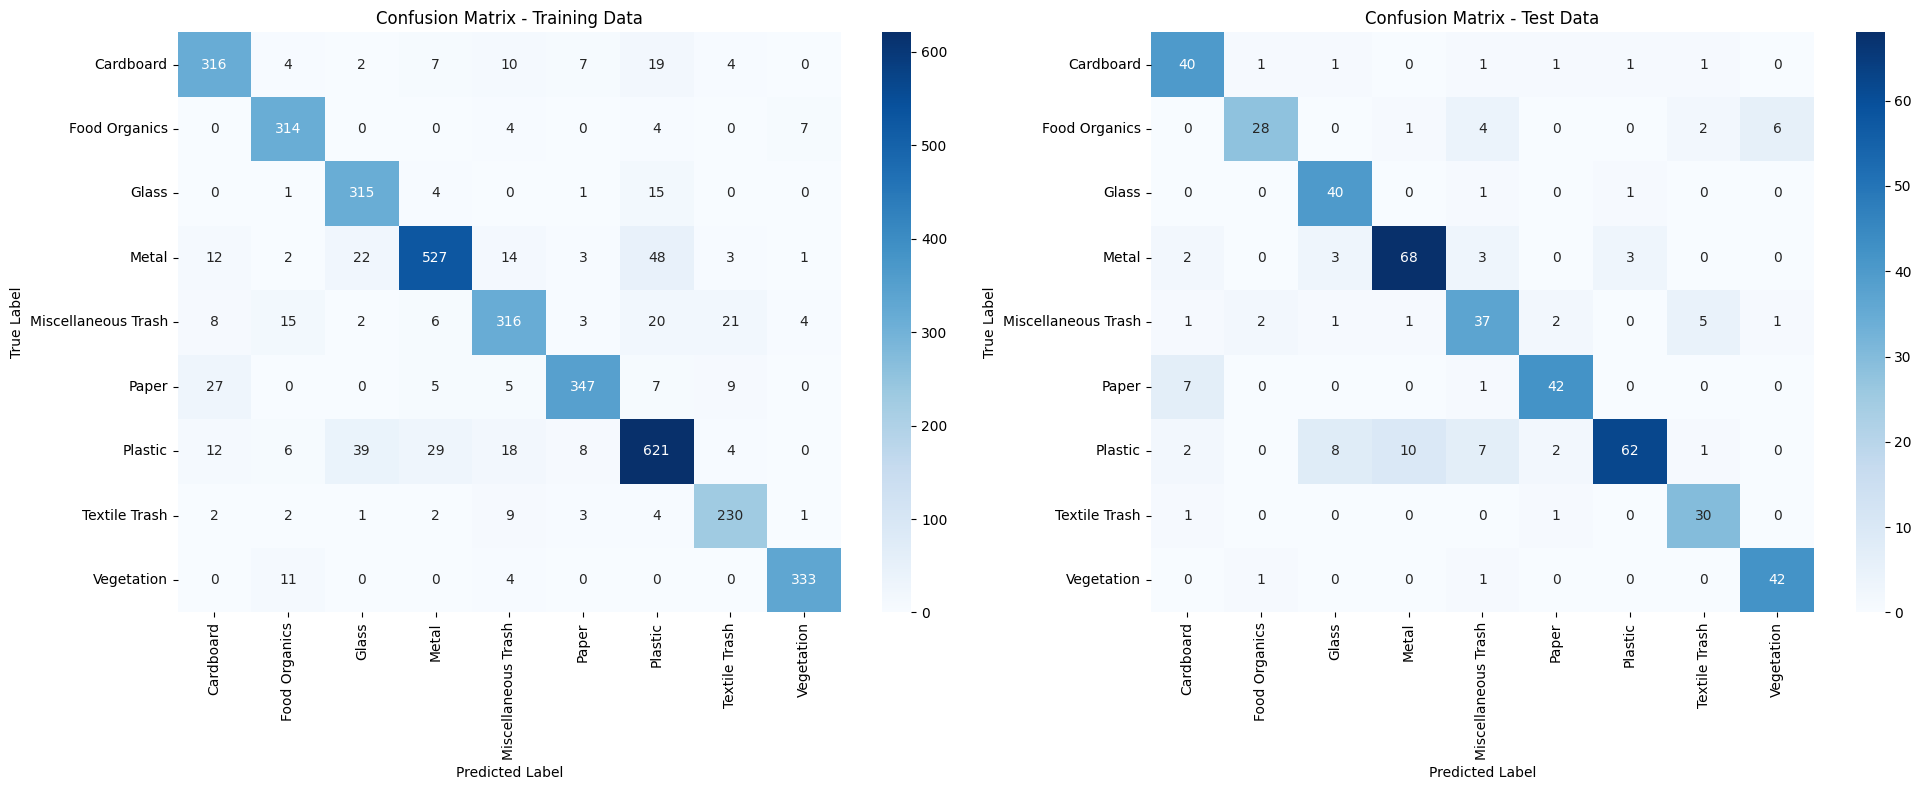

In [39]:
# Generate the confusion matrices
cm_train = confusion_matrix(y_true_train, y_pred_class_train)
cm_test = confusion_matrix(y_true, y_pred_class)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot confusion matrix for the training data
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_title('Confusion Matrix - Training Data')

# Plot confusion matrix for the test data
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_title('Confusion Matrix - Test Data')

# Display the plots
plt.tight_layout()
plt.show()

## Model Saving


In [40]:
# Model summary
model.trainable = False
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 9)                 2313      
                                                                 
Total params: 22,329,641
Trainable params: 0
Non-trainable params: 22,329,641
____________________________________________

In [ ]:
# Save the model
model.save('final_model.h5')